## Import packages

In [2]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [5]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [6]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

final_ds = xr.open_dataset('../aht_time_series/aaron_aht_data_through_2018_with_time.nc')

### Load stream functions

In [7]:
strm_ds = xr.open_dataset('strm_functions.nc').sel(time=slice('1980','2018'))

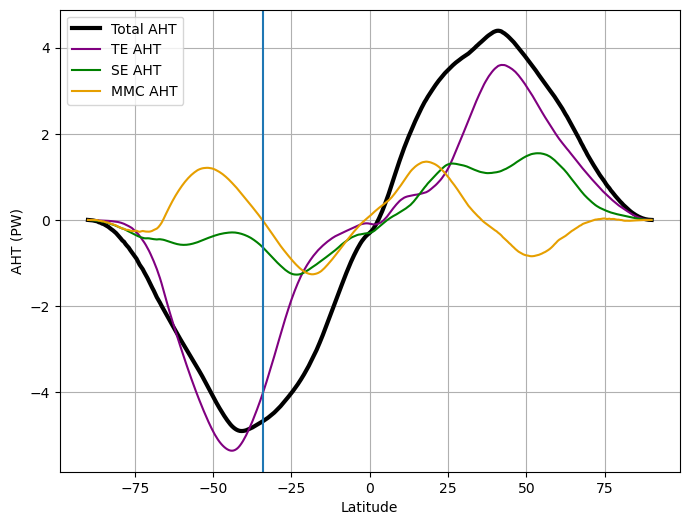

In [8]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_clima.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_clima.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, aht_clima.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')

plt.axvline(-34)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

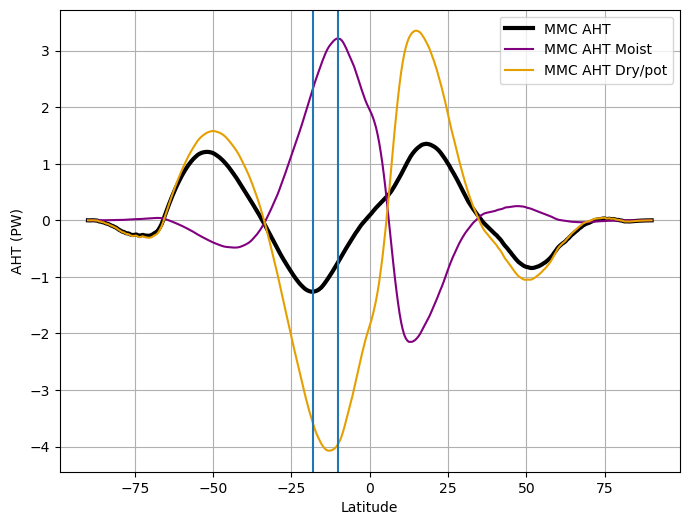

In [9]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.mmc_aht / 1e15, color='k', lw=3, label='MMC AHT')
plt.plot(lats, aht_clima.mmc_aht_moist / 1e15, color='purple', label='MMC AHT Moist')
plt.plot(lats, aht_clima.mmc_aht_dry_pot / 1e15, color='#E69F00', label='MMC AHT Dry/pot')

plt.axvline(-10)
plt.axvline(-18)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

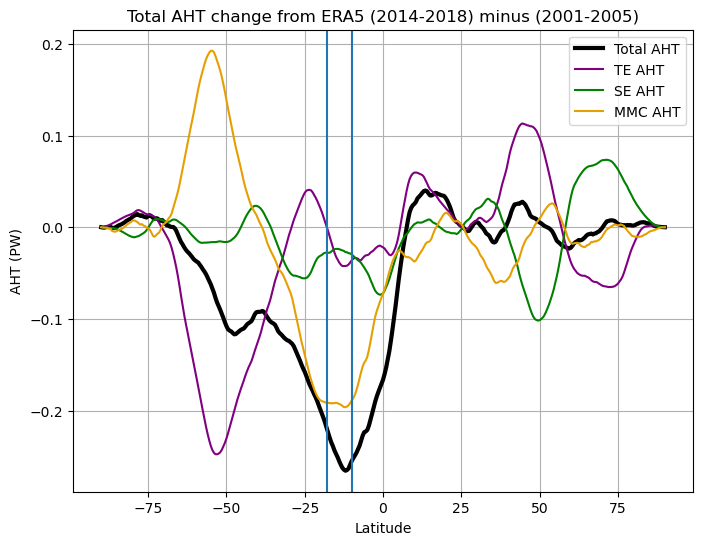

In [10]:
plt.figure(figsize=(8,6))

aht_change = final_ds.sel(time=slice('2009-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('1980-01-01', '1989-12-31')).mean(['time'])
#For ceres only timeframe
#aht_change = final_ds.sel(time=slice('2014-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('2001-01-01', '2005-12-31')).mean(['time'])


plt.plot(lats, aht_change.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_change.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_change.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, aht_change.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')


#plt.plot(lats, aht_change.mmc_aht / 1e15, color='k', lw=3, label='Total')
#plt.plot(lats, aht_change.total_aht_dry / 1e15, color='r', lw=3, label='Dry AHT')
#plt.plot(lats, aht_change.mmc_aht_moist / 1e15, color='b', label='Moist AHT')
#plt.plot(lats, aht_change.total_aht_pot / 1e15, color='g', label='Pot AHT')
#plt.plot(lats, aht_change.mmc_aht_dry_pot / 1e15, color='g', label='Dry + Pot AHT')

plt.axvline(-10)
plt.axvline(-18)
plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')
plt.title('Total AHT change from ERA5 (2014-2018) minus (2001-2005)')
#plt.savefig('../figures/5_24_22_meeting/aht_changes_era5_ceres_era')
plt.show()

### Let's see trends by month in various places

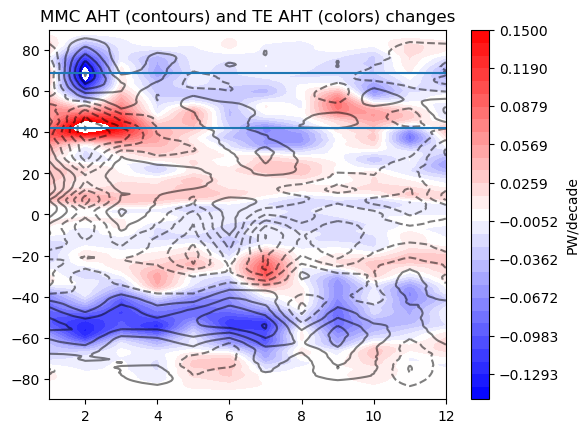

In [105]:


month_grouped = final_ds.groupby('time.month')

monthly_trends_te = np.zeros((12, len(lats)))
monthly_trends_mmc = np.zeros((12, len(lats)))
monthly_trends_se = np.zeros((12, len(lats)))
monthly_trends_total = np.zeros((12, len(lats)))

for i in range(12):
    
    data_new_time_dim = month_grouped[i+1].assign_coords({"time": range(39)})
    this_trend = data_new_time_dim.polyfit(dim='time', deg=1)
    monthly_trends_te[i,:] = this_trend.te_aht_polyfit_coefficients.sel(degree=1)
    monthly_trends_mmc[i,:] = this_trend.mmc_aht_polyfit_coefficients.sel(degree=1)
    monthly_trends_se[i,:] = this_trend.se_aht_polyfit_coefficients.sel(degree=1)
    monthly_trends_total[i,:] = this_trend.total_aht_polyfit_coefficients.sel(degree=1)

contf=plt.contourf(range(1, 13), lats, 10*monthly_trends_te.T/1e15, levels=np.linspace(-.15, .15, 30), cmap='bwr')

plt.contour(range(1, 13), lats, 10*monthly_trends_mmc.T/1e15, levels=np.linspace(-.15, .15, 10), colors='k', alpha=0.5)

plt.colorbar(contf,label='PW/decade')

plt.title('MMC AHT (contours) and TE AHT (colors) changes')

plt.axhline(69)
plt.axhline(42)

#plt.savefig('../figures/aht_changes/te_aht_mmc_aht_changes')
plt.show()

In [48]:
print(10 * monthly_trends_total[1, era_fncts.get_lat_idx(69)] / 1e15)
print(final_ds.total_aht.sel(latitude=69).mean(['time']).values / 1e15)

-0.05124480712067052
1.5870008111049343


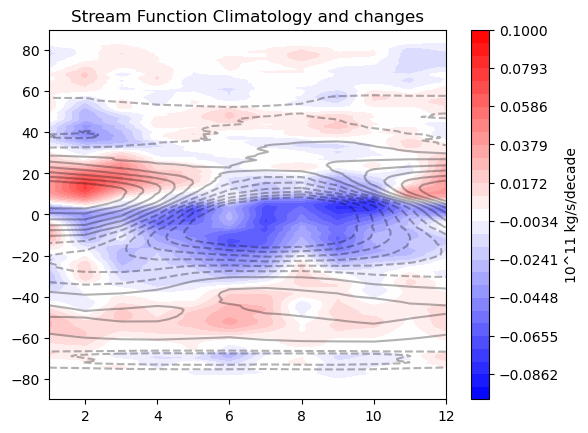

In [66]:


month_grouped_strm = strm_ds.groupby('time.month')

monthly_trends_strm = np.zeros((12, len(lats)))

for i in range(12):
    
    data_new_time_dim = month_grouped_strm[i+1].assign_coords({"time": range(39)}).sel(level=700)
    this_trend = data_new_time_dim.polyfit(dim='time', deg=1)
    monthly_trends_strm[i,:] = this_trend.strm_fnct_polyfit_coefficients.sel(degree=1)

plt.contour(range(1,13), lats, month_grouped_strm.mean(['time']).sel(level=700).strm_fnct.T/1e11,
            levels=np.linspace(-1.5, 1.5, 12), colors='k', alpha=0.3)

plt.contourf(range(1,13), lats, 10 * monthly_trends_strm.T/1e11,
            levels=np.linspace(-.1, .1, 30), cmap='bwr')

plt.colorbar(label='10^11 kg/s/decade')

plt.title('Stream Function Climatology and changes')

#plt.savefig('../figures/aht_changes/total_aht_clima_and_changes')
plt.show()

In [61]:
month_grouped_strm.mean(['time']).strm_fnct.sel(level=700)

<xarray.DataArray 'strm_fnct' (month: 12, latitude: 361)>
array([[ 1.22068344e-01, -8.25381009e+06, -1.93658813e+07, ...,
         2.78322169e-08,  2.92474840e-09, -1.87923613e-16],
       [ 5.28499744e-02, -1.09331785e+07, -2.01031559e+07, ...,
         1.96294143e-08,  1.90368901e-09, -1.78198240e-16],
       [ 4.41335182e-02, -1.53950136e+07, -2.97741723e+07, ...,
         4.03214915e-08,  5.08645406e-09, -3.42142999e-16],
       ...,
       [-1.14450084e-02, -1.35157050e+07, -2.37461474e+07, ...,
         4.35333603e-08,  8.67518023e-10, -3.58046818e-16],
       [ 3.41534159e-03, -3.77653270e+06, -9.86652068e+05, ...,
         3.47693761e-08,  1.28952356e-09, -1.68991114e-16],
       [ 1.35847711e-01, -4.44894845e+06, -8.76079786e+06, ...,
         4.03334315e-08,  1.03281286e-09, -2.35914340e-16]])
Coordinates:
  * latitude  (latitude) float64 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
    level     int64 700
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Let's look at the time series for February

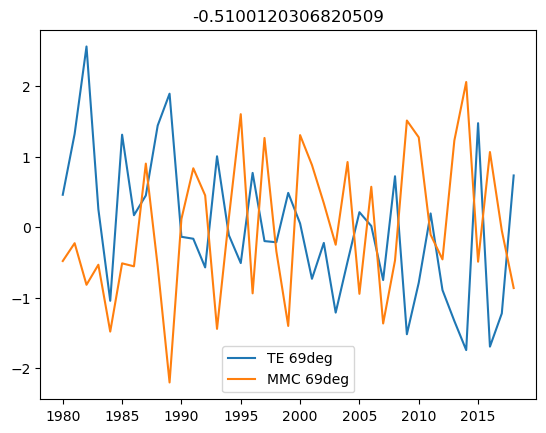

In [54]:
te_time_series_69 = month_grouped[2].te_aht.sel(latitude=69)
te_time_series_42 = month_grouped[2].te_aht.sel(latitude=42)
mmc_time_series_69 = month_grouped[2].mmc_aht.sel(latitude=69)
mmc_time_series_42 = month_grouped[2].mmc_aht.sel(latitude=42)
total_time_series_69 = month_grouped[2].total_aht.sel(latitude=69)
total_time_series_42 = month_grouped[2].total_aht.sel(latitude=42)

plt.plot(range(1980, 2019), normalize_time_series(te_time_series_69), label='TE 69deg')
plt.plot(range(1980, 2019), normalize_time_series(mmc_time_series_69), label='MMC 69deg')
#plt.plot(range(1980, 2019), normalize_time_series(total_time_series_69), label='Total 69deg')

plt.legend(loc=0)

corr_coef = np.corrcoef(signal.detrend(te_time_series_69), signal.detrend(mmc_time_series_69))[1,0]

plt.title(corr_coef)
plt.show()

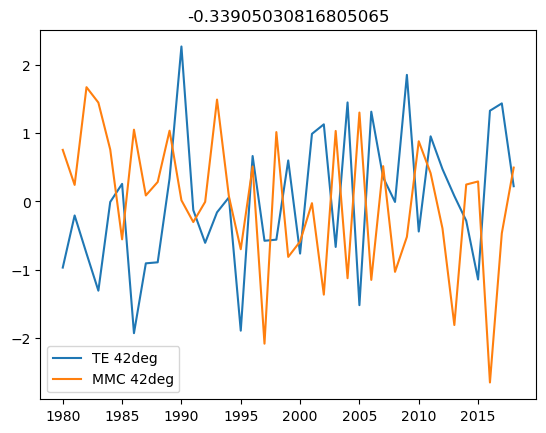

In [52]:
plt.plot(range(1980, 2019), normalize_time_series(te_time_series_42), label='TE 42deg')
plt.plot(range(1980, 2019), normalize_time_series(mmc_time_series_42), label='MMC 42deg')
#plt.plot(range(1980, 2019), normalize_time_series(total_time_series_42), label='Total 42deg')

plt.legend(loc=0)

corr_coef = np.corrcoef(signal.detrend(te_time_series_42), signal.detrend(mmc_time_series_42))[1,0]

plt.title(corr_coef)
plt.show()

### Trends in MMC AHT and streamfunctions

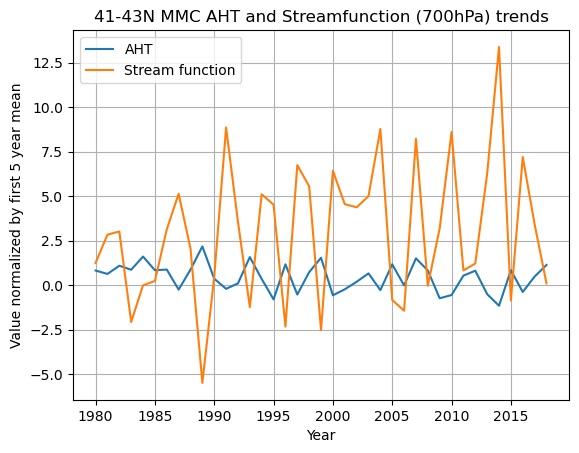

In [79]:
mmc_aht = final_ds.mmc_aht.sel(latitude=slice(70, 68)).groupby('time.month')[2].mean(['latitude'])
mmc_strm = strm_ds.strm_fnct.sel(latitude=slice(70, 68), level=700).groupby('time.month')[2].mean(['latitude'])


plt.plot(range(1980, 2019), mmc_aht / np.mean(mmc_aht[0:5]), label='AHT')
plt.plot(range(1980, 2019), mmc_strm / np.mean(mmc_strm[0:5]), label='Stream function')

plt.legend(loc=0)

plt.ylabel('Value normalized by first 5 year mean')
plt.xlabel('Year')

#plt.title('18S MMC AHT trends')
plt.title('41-43N MMC AHT and Streamfunction (700hPa) trends')

plt.grid()

#plt.savefig('../figures/aht_changes/mmc_aht__strm_fnct_700hPa_10_to_20S_norm_by_1st_5_year_mean')

plt.show()

### Look at trends in MSE gradients

In [86]:
mse_data = xr.open_dataset('../era5_raw_data/monthly_surf_temps_sphum.nc').sel(time=slice('1980', '2018'))
mse_data['mse'] = mse_data.t * cp + mse_data.q * L

mse_data['mse_grad'] = mse_data['mse'].differentiate('latitude')
mse_data['t_grad'] = mse_data['t'].differentiate('latitude')
mse_data['q_grad'] = mse_data['q'].differentiate('latitude')

In [92]:
lats_fine = mse_data.latitude.values

In [90]:
month_grouped_mse = mse_data.mean(['longitude']).groupby('time.month')

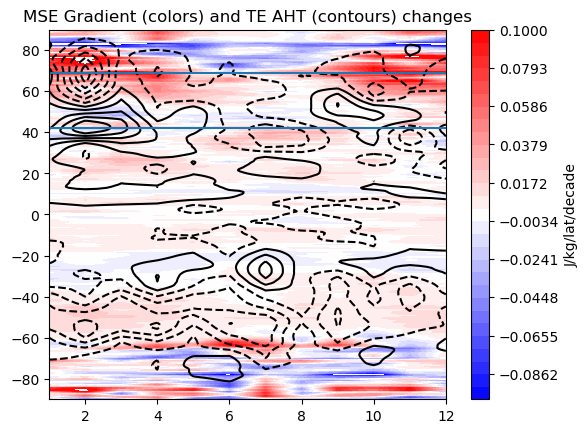

In [120]:

monthly_trends_mse = np.zeros((12, len(lats_fine)))
monthly_trends_t = np.zeros((12, len(lats_fine)))
monthly_trends_q = np.zeros((12, len(lats_fine)))


for i in range(12):
    
    data_new_time_dim = month_grouped_mse[i+1].assign_coords({"time": range(39)})
    this_trend = data_new_time_dim.polyfit(dim='time', deg=1)
    monthly_trends_mse[i,:] = this_trend.mse_grad_polyfit_coefficients.sel(degree=1)
    monthly_trends_t[i,:] = this_trend.t_grad_polyfit_coefficients.sel(degree=1)
    monthly_trends_q[i,:] = this_trend.q_grad_polyfit_coefficients.sel(degree=1)

#contf=plt.contourf(range(1, 13), lats_fine, -10*monthly_trends_mse.T, levels=np.linspace(-150, 150, 30), cmap='bwr')
contf=plt.contourf(range(1, 13), lats_fine, 10*monthly_trends_t.T, levels=np.linspace(-.1, .1, 30), cmap='bwr')
#plt.contour(range(1,13), lats_fine, month_grouped_mse.mean(['time']).mse_grad.T,
            #levels=np.linspace(-5000, 5000, 12), colors='k', alpha=0.3)

plt.contour(range(1, 13), lats, 10*monthly_trends_te.T/1e15, levels=np.linspace(-.15, .15, 10), colors='k')
    
plt.colorbar(contf,label='J/kg/lat/decade')

plt.title('MSE Gradient (colors) and TE AHT (contours) changes')

plt.axhline(69)
plt.axhline(42)

#plt.ylim([0, 90])

#plt.savefig('../figures/aht_changes/te_aht_mse_grad_changes')
plt.show()

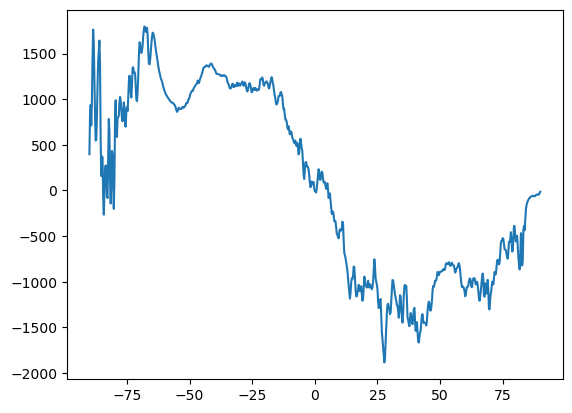

In [97]:
plt.plot(lats_fine, month_grouped_mse.mean(['time']).mse_grad.mean(['month']))

plt.show()